In [1]:
import qcodes

from qcodes.dataset import Measurement, load_or_create_experiment, plot_dataset

import numpy as np

import scipy

import matplotlib.pyplot as plt

## Measuring Current Pre-Amp Bias

In [2]:
# Load in Station
station = qcodes.Station(config_file='../station_config.yml')
station.load_instrument('sim900')
station.load_instrument('agilent')

Connected to: Stanford_Research_Systems SIM900 (serial:s/n130900, firmware:ver3.6) in 1.72s
Connected to: HEWLETT-PACKARD 34401A (serial:0, firmware:11-5-3) in 0.07s


<Agilent34401A: agilent>

In [3]:
preamp_bias_exp = load_or_create_experiment('Current PreAmp-2 Bias Experiment', sample_name='10MOhm Resistor')

In [4]:
VI_sweep = Measurement(exp=preamp_bias_exp)

In [5]:
VI_sweep.register_parameter(station.sim900.volt_1) # Record independent variable
VI_sweep.register_parameter(station.agilent.volt, setpoints=[station.sim900.volt_1]) # Record dependent variable (setpoints implies dependency)

dV = 1e-3 # min resolution
volt_min, volt_max = -10e-3, 10e-3
voltage_sweep = np.arange(volt_min, volt_max, dV) # sweep values
station.sim900.set_smooth({1: volt_min}) # smoothly ramp to start point

with VI_sweep.run() as datasaver:
    for voltage in voltage_sweep:
        station.sim900.volt_1.set(voltage) # set voltage (mV)
        datasaver.add_result(
            (station.sim900.volt_1, station.sim900.volt_1()),
            (station.agilent.volt, station.agilent.volt())
            ) # record measurement
        
station.sim900.set_smooth({1: 0}) # smoothly ramp to 0V after measurement
dataset = datasaver.dataset

Starting experimental run with id: 25. 


Resistance is 10.021719 MΩ
Y-Intercept is (0 mV, -0.149827 nA)
X-Intercept is (1.501526 mV, 0 nA)


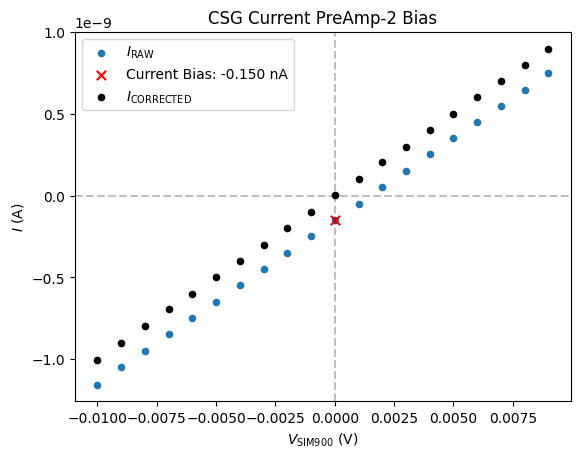

In [23]:
df = dataset.to_pandas_dataframe().reset_index()

df_current = df.copy()
df_current = df_current.rename(columns={'agilent_volt': 'agilent_current'})
df_current.iloc[:,1] = df_current.iloc[:,1].mul(-1e-6) # sensitivity

V = df_current['sim900_volt_1'] # V
I = df_current['agilent_current'] # A

def linear(x, m, b):
    return m * x + b

fit_params, pcov = scipy.optimize.curve_fit(linear, xdata=V, ydata=I, p0=(1, 0))

G, IBias = fit_params

R = 1/G

print("Resistance is {:3f} M\u03A9".format(R/1e6))
print("Y-Intercept is (0 mV, {:3f} nA)".format(IBias/1e-9))
print("X-Intercept is ({:3f} mV, 0 nA)".format((-IBias/G) / 1e-3))

axes = df_current.plot.scatter(y='agilent_current', x='sim900_volt_1', linewidth=1, s=20, label=r'$I_{\text{RAW}}$')
axes.axhline(y=0, color='k', alpha=0.25, linestyle='--')
axes.axvline(x=0, color='k', alpha=0.25, linestyle='--')
axes.scatter([0],[IBias], s=45, marker='x', c='r', label='Current Bias: {:.3f} nA'.format(IBias/1e-9))
axes.set_ylabel(r'$I$ (A)')
axes.set_xlabel(r'$V_{\text{SIM900}}$ (V)')
axes.set_title('CSG Current PreAmp-2 Bias')

df_current_nobias = df_current.copy()
# subtract the bias
df_current_nobias.iloc[:,1] = df_current_nobias.iloc[:,1].subtract(IBias)
axes.scatter(df_current_nobias['sim900_volt_1'], df_current_nobias['agilent_current'], color='k', s=20, label=r'$I_{\text{CORRECTED}}$')
axes.legend(loc='best')

## Multidimensional Sweeps

## 1. Global Turn On